In [1]:
!pip install -q -U tensorflow>=1.8.0
import tensorflow as tf
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from keras.layers import Input, Lambda, Dense, Flatten
from keras.models import Model
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from keras.models import Sequential
from glob import glob
import os, time


**Load Dataset**

In [2]:
dataset = np.load('fashion_mnist_dataset_train.npy', allow_pickle=True).item()

In [3]:
X = dataset['features']
y = dataset['target']

In [4]:
X.shape, y.shape

((60000, 28, 28), (60000,))

In [5]:
y

array([5., 2., 1., ..., 3., 1., 4.])

In [6]:
y = y-1

In [7]:
y

array([4., 1., 0., ..., 2., 0., 3.])

In [8]:
from tensorflow.keras.utils import to_categorical
y = to_categorical(y, 5)

In [9]:
y

array([[0., 0., 0., 0., 1.],
       [0., 1., 0., 0., 0.],
       [1., 0., 0., 0., 0.],
       ...,
       [0., 0., 1., 0., 0.],
       [1., 0., 0., 0., 0.],
       [0., 0., 0., 1., 0.]], dtype=float32)

In [10]:
y.shape

(60000, 5)

In [11]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from tensorflow.python import keras
from tensorflow.python.keras.models import Sequential
from tensorflow.python.keras.layers import Dense, Flatten, Conv2D, Dropout, MaxPooling2D
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
from keras.utils import plot_model
from tensorflow.keras.optimizers import Adam, SGD

In [12]:
# train - val - test split (80%-10%-10% , random seed =0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0)
X_test, X_val, y_test, y_val = train_test_split(X_test, y_test, test_size=0.5, random_state=0)

In [13]:
X_train.shape, y_train.shape

((48000, 28, 28), (48000, 5))

In [14]:
X_train = tf.expand_dims(X_train, axis=-1)
X_val = tf.expand_dims(X_val, axis=-1)
X_test = tf.expand_dims(X_test, axis=-1)

In [15]:
X_train.shape, X_val.shape, X_test.shape

(TensorShape([48000, 28, 28, 1]),
 TensorShape([6000, 28, 28, 1]),
 TensorShape([6000, 28, 28, 1]))

In [16]:

# from keras.preprocessing.image import img_to_array, array_to_img
# X_train = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in X_train])
# X_val = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in X_val])
# X_test = np.asarray([img_to_array(array_to_img(im, scale=False).resize((32,32))) for im in X_test])
# #train_x = preprocess_input(x)
# X_train.shape, X_val.shape, X_test.shape

**Transfer Learning VGGNet**

In [17]:
# Resize the images 32*32 as required by VGG16
# pad zeros to make 28*28*1 array to 32*32*3 array
X_train = np.pad(X_train,((0,0),(2,2),(2,2),(1,1)), mode='constant', constant_values=0)
X_val = np.pad(X_val,((0,0),(2,2),(2,2),(1,1)), mode='constant', constant_values=0)
X_test = np.pad(X_test,((0,0),(2,2),(2,2),(1,1)), mode='constant', constant_values=0)

X_train.shape, X_val.shape, X_test.shape

((48000, 32, 32, 3), (6000, 32, 32, 3), (6000, 32, 32, 3))

In [18]:
IMAGE_SIZE = [32, 32,3]
NUM_CLASSES = 5

# add preprocessing layer to the front of VGG
vgg_net = VGG16(input_shape=IMAGE_SIZE, weights='imagenet', include_top=False)

# don't train existing weights
for layer in vgg_net.layers:
  layer.trainable = False

# adding flatten and output layer to the resnet architecture
x = Flatten()(vgg_net.output)
prediction = Dense(NUM_CLASSES, activation='softmax')(x)

# create a model object
model = Model(inputs=vgg_net.input, outputs=prediction)

# Compile the model
model.compile(loss='categorical_crossentropy',
             optimizer= Adam(),
             metrics=['accuracy'])

In [19]:
model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, 32, 32, 3)]       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 32, 32, 64)        1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 32, 32, 64)        36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 16, 16, 64)        0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 16, 16, 128)       73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 16, 16, 128)       147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 8, 8, 128)         0     

**Train Model**

In [20]:
# Train the the model
start_time = time.time()

train_model = model.fit(X_train, y_train, batch_size=128, epochs=50, verbose=1, validation_data=(X_val, y_val))

end_time = time.time()
vgg16_time = end_time - start_time
print("Total training time is {:0.2f} minute".format(vgg16_time/60.0))

Epoch 1/50
375/375 [==============================] - 12s 20ms/step - loss: 1.1894 - accuracy: 0.5436 - val_loss: 0.7976 - val_accuracy: 0.6968
Epoch 2/50
375/375 [==============================] - 6s 17ms/step - loss: 0.7584 - accuracy: 0.7199 - val_loss: 0.6897 - val_accuracy: 0.7450
Epoch 3/50
375/375 [==============================] - 6s 17ms/step - loss: 0.6707 - accuracy: 0.7458 - val_loss: 0.6410 - val_accuracy: 0.7572
Epoch 4/50
375/375 [==============================] - 7s 17ms/step - loss: 0.6261 - accuracy: 0.7607 - val_loss: 0.6062 - val_accuracy: 0.7670
Epoch 5/50
375/375 [==============================] - 6s 17ms/step - loss: 0.5948 - accuracy: 0.7714 - val_loss: 0.5842 - val_accuracy: 0.7802
Epoch 6/50
375/375 [==============================] - 6s 17ms/step - loss: 0.5857 - accuracy: 0.7708 - val_loss: 0.5738 - val_accuracy: 0.7810
Epoch 7/50
375/375 [==============================] - 7s 17ms/step - loss: 0.5718 - accuracy: 0.7762 - val_loss: 0.5578 - val_accuracy: 0.784

**Test Accuracy**

In [21]:
score = model.evaluate(X_train, y_train, verbose=0)
print('Train loss:', score[0])
print('Train accuracy:', score[1])

Train loss: 0.44862622022628784
Train accuracy: 0.8244374990463257


In [22]:
score = model.evaluate(X_val, y_val, verbose=0)
print('Val loss:', score[0])
print('Val accuracy:', score[1])

Val loss: 0.4596065580844879
Val accuracy: 0.8176666498184204


In [23]:
%%time 
score = model.evaluate(X_test, y_test, verbose=0)
print('Test loss:', score[0])
print('Test accuracy:', score[1])

Test loss: 0.4575856924057007
Test accuracy: 0.8181666731834412
CPU times: user 761 ms, sys: 182 ms, total: 942 ms
Wall time: 1.6 s


**Accuracy-Loss Plots**

In [24]:
def accuracy_loss_plot(model):

  hist = model.history
  acc = hist['accuracy']
  val_acc = hist['val_accuracy']
  loss = hist['loss']
  val_loss = hist['val_loss']
  epoch = range(50)

  fig = plt.figure(figsize = (12,10))
  plt.subplot(2,2,1)
  sns.lineplot(acc,loss)
  plt.xlabel('Accuracy')
  plt.ylabel('Loss')
  plt.legend(['train set'], loc='upper right')
  plt.title('Training Accuracy vs Loss')

  plt.subplot(2,2,2)
  sns.lineplot(val_acc,val_loss)
  plt.xlabel('Accuracy')
  plt.ylabel('Loss')
  plt.legend(['validation set'], loc='upper right')
  plt.title('Validation Accuracy vs Loss')

  plt.subplot(2,2,3)
  sns.lineplot(epoch, acc)
  sns.lineplot(epoch, val_acc)
  plt.xlabel('Epoch')
  plt.ylabel('Accuracy')
  plt.legend(['train set', 'validation set'], loc='lower right')
  plt.title('Accuracy vs Epoch')

  plt.subplot(2,2,4)
  sns.lineplot(epoch, loss)
  sns.lineplot(epoch, val_loss)
  plt.xlabel('Epoch')
  plt.ylabel('Loss')
  plt.legend(['train set', 'validation set'], loc='upper right')
  plt.title('Loss vs Epoch')

  plt.show()


/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variables as keyword args: x, y. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning
/usr/local/lib/python3.7/dist-package

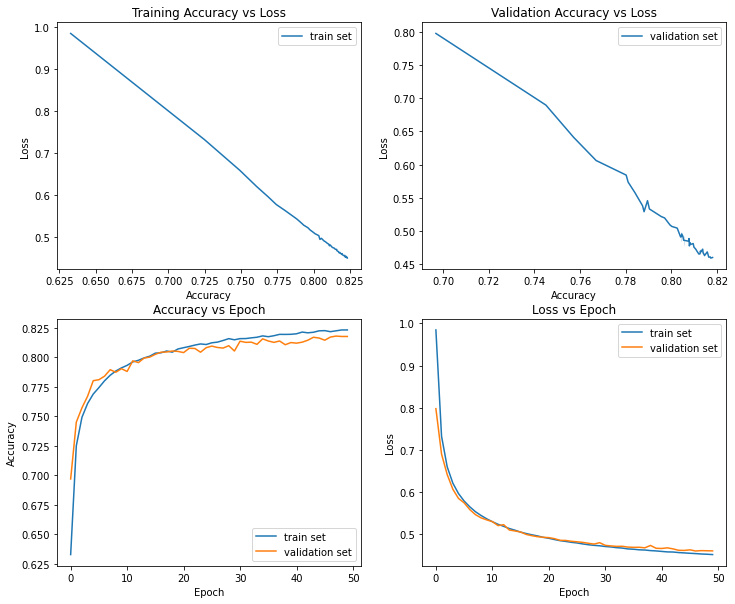

In [25]:
accuracy_loss_plot(train_model)